In [1]:
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import jax
import jax.numpy as jnp
from jax.scipy.special import logsumexp
from jax.scipy.stats import norm, expon, multivariate_normal
from numpy.linalg import inv
from scipy.linalg import eigh

import numpyro
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

/global/homes/r/rgrumitt/.conda/envs/jax/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
RANDOM_SEED = 123446
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

# Define Matern52 kernel for modelling Gaussian Random Field

In [3]:
def distance_matrix(x, y):
    return jnp.sqrt(jnp.sum(jnp.abs(x[:, jnp.newaxis, :] - y[jnp.newaxis, :, :]) ** 2, axis=-1))


class SquaredExponential:
    def __init__(self, coords, mkl, lamb):
        """
        This class sets up a random process
        on a grid and generates
        a realisation of the process, given
        parameters or a random vector.
        """

        # Internalise the grid and set number of vertices.
        self.coords = coords
        self.n_points = self.coords.shape[0]
        self.eigenvalues = None
        self.eigenvectors = None
        self.parameters = None
        self.random_field = None

        # Set some random field parameters.
        self.mkl = mkl
        self.lamb = lamb

        self.assemble_covariance_matrix()

    def assemble_covariance_matrix(self):
        """
        Create a snazzy distance-matrix for rapid
        computation of the covariance matrix.
        """
        dist = distance_matrix(self.coords, self.coords)

        # Compute the covariance between all
        # points in the space.
        self.cov = jnp.exp(-0.5 * dist**2 / self.lamb**2)

    def plot_covariance_matrix(self):
        """
        Plot the covariance matrix.
        """
        plt.figure(figsize=(10, 8))
        plt.imshow(self.cov, cmap="binary")
        plt.colorbar()
        plt.show()

    def compute_eigenpairs(self):
        """
        Find eigenvalues and eigenvectors using Arnoldi iteration.
        """
        eigvals, eigvecs = eigh(self.cov, eigvals=(self.n_points - self.mkl, self.n_points - 1))

        order = jnp.flip(jnp.argsort(eigvals))
        self.eigenvalues = jnp.asarray(eigvals[order])
        self.eigenvectors = jnp.asarray(eigvecs[:, order])

    def generate(self, parameters=None, key=None):
        """
        Generate a random field, see
        Scarth, C., Adhikari, S., Cabral, P. H.,
        Silva, G. H. C., & Prado, A. P. do. (2019).
        Random field simulation over curved surfaces:
        Applications to computational structural mechanics.
        Computer Methods in Applied Mechanics and Engineering,
        345, 283–301. https://doi.org/10.1016/j.cma.2018.10.026
        """

        if parameters is None:
            if key is None:
                key = jax.random.PRNGKey(0)
            self.parameters = jax.random.normal(key, shape=(self.mkl,))
        else:
            self.parameters = jnp.array(parameters).flatten()

        self.random_field = jnp.linalg.multi_dot(
            (self.eigenvectors, jnp.sqrt(jnp.diag(self.eigenvalues)), self.parameters)
        )

    def plot(self, lognormal=True):
        """
        Plot the random field.
        """

        if lognormal:
            random_field = self.random_field
            contour_levels = jnp.linspace(min(random_field), max(random_field), 20)
        else:
            random_field = jnp.exp(self.random_field)
            contour_levels = jnp.linspace(min(random_field), max(random_field), 20)

        plt.figure(figsize=(12, 10))
        plt.tricontourf(
            self.coords[:, 0],
            self.coords[:, 1],
            random_field,
            levels=contour_levels,
            cmap="plasma",
        )
        plt.colorbar()
        plt.show()


class Matern52(SquaredExponential):
    def assemble_covariance_matrix(self):
        """
        This class inherits from RandomProcess and creates a Matern 5/2 covariance matrix.
        """

        # Compute scaled distances.
        dist = jnp.sqrt(5.0) * distance_matrix(self.coords, self.coords) / self.lamb

        # Set up Matern 5/2 covariance matrix.
        self.cov = (1 + dist + dist**2 / 3) * jnp.exp(-dist)

# Define the Gravity model and generate data

In [4]:
# Set the model parameters.
depth = 0.1
n_quad = 64
n_data = 10

# noise level
noise_level = 0.1

# Set random process parameters.
lamb = 0.3
mkl = 60

In [5]:
class Gravity:
    """
    Gravity is a class that implements a simple gravity surveying problem,
    as described in Hansen, P. C. (2010). Discrete Inverse Problems: Insight and Algorithms.
    Society for Industrial and Applied Mathematics.
    It uses midpoint quadrature to evaluate a Fredholm integral of the first kind.
    """

    def __init__(self, f_function, depth, n_quad, n_data):

        # Set the function describing the distribution of subsurface density.
        self.f_function = f_function

        # Set the depth of the density (distance to the surface measurements).
        self.depth = depth

        # Set the quadrature degree along one dimension.
        self.n_quad = n_quad

        # Set the number of data points along one dimension
        self.n_data = n_data

        # Set the quadrature points.
        x = jnp.linspace(0, 1, self.n_quad + 1)
        self.tx = (x[1:] + x[:-1]) / 2
        y = jnp.linspace(0, 1, self.n_quad + 1)
        self.ty = (y[1:] + y[:-1]) / 2
        TX, TY = jnp.meshgrid(self.tx, self.ty)

        # Set the measurement points.
        self.sx = jnp.linspace(0, 1, self.n_data)
        self.sy = jnp.linspace(0, 1, self.n_data)
        SX, SY = jnp.meshgrid(self.sx, self.sy)

        # Create coordinate vectors.
        self.T_coords = jnp.c_[TX.ravel(), TY.ravel(), np.zeros(self.n_quad**2)]
        self.S_coords = jnp.c_[SX.ravel(), SY.ravel(), self.depth * jnp.ones(self.n_data**2)]

        # Set the quadrature weights.
        self.w = 1 / self.n_quad**2

        # Compute a distance matrix
        dist = distance_matrix(self.S_coords, self.T_coords)

        # Create the Fremholm kernel.
        self.K = self.w * self.depth / dist**3

        # Evaluate the density function on the quadrature points.
        self.f = self.f_function(TX, TY).flatten()

        # Compute the surface density (noiseless measurements)
        self.g = jnp.dot(self.K, self.f)

    def plot_model(self):

        # Plot the density and the signal.
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        axes[0].set_title("Density")
        f = axes[0].imshow(
            self.f.reshape(self.n_quad, self.n_quad),
            extent=(0, 1, 0, 1),
            origin="lower",
            cmap="plasma",
        )
        fig.colorbar(f, ax=axes[0])
        axes[1].set_title("Signal")
        g = axes[1].imshow(
            self.g.reshape(self.n_data, self.n_data),
            extent=(0, 1, 0, 1),
            origin="lower",
            cmap="plasma",
        )
        fig.colorbar(g, ax=axes[1])
        plt.show()

    def plot_kernel(self):

        # Plot the kernel.
        plt.figure(figsize=(8, 6))
        plt.imshow(self.K, cmap="plasma")
        plt.colorbar()
        plt.show()

In [6]:
# This is a function describing the subsurface density.
def f(TX, TY):
    f = np.sin(np.pi * TX) + np.sin(3 * np.pi * TY) + TY + 1
    f = f / f.max()
    return f

In [7]:
# Initialise a model
model_true = Gravity(f, depth, n_quad, n_data)

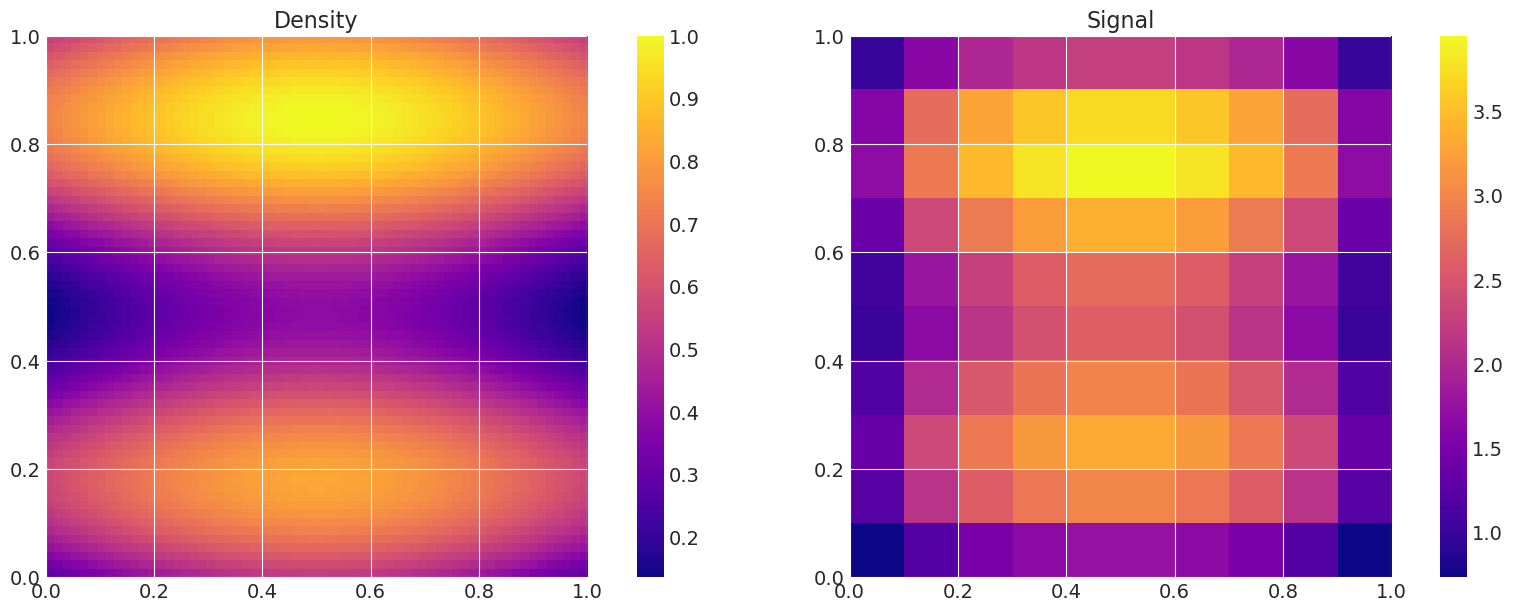

In [8]:
model_true.plot_model()

In [9]:
np.mean(model_true.f)

Array(0.612292, dtype=float32)

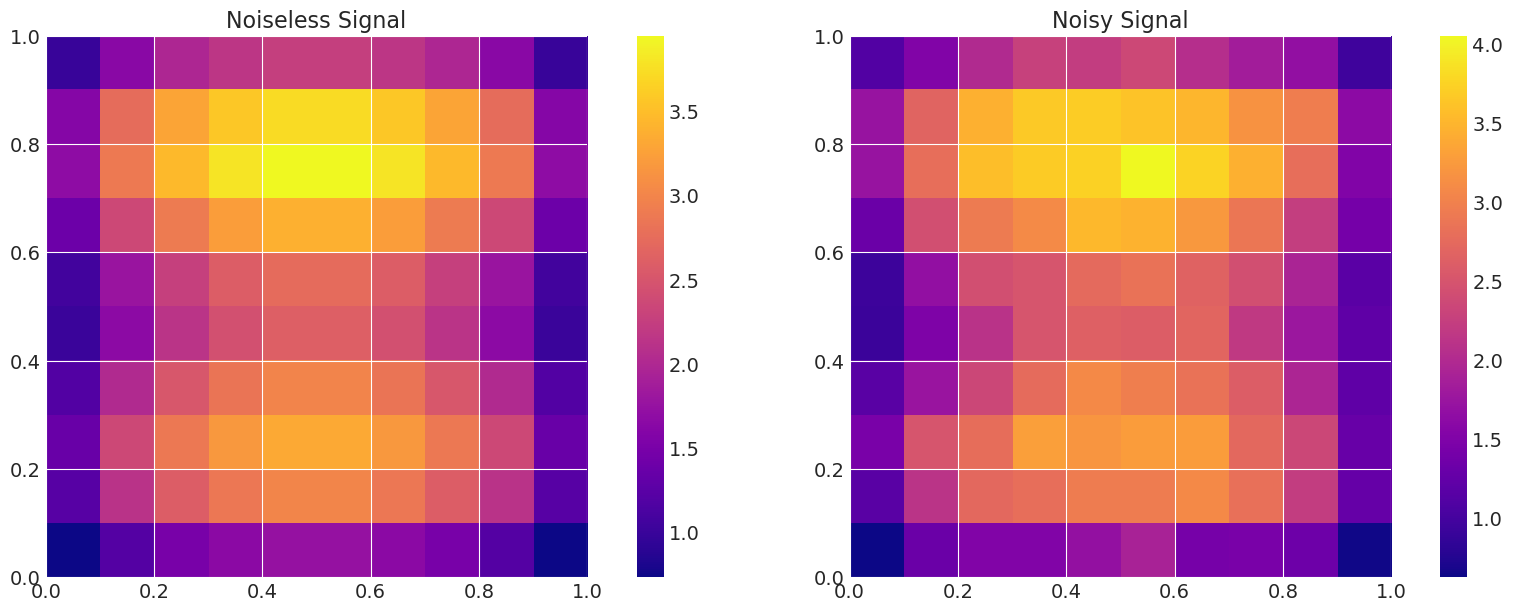

In [10]:
# Add noise to the data.
# Leave like this so we have the same data!
np.random.seed(123)
noise = np.random.normal(0, noise_level, n_data**2)
obs_cov = noise_level ** 2 * jnp.eye(n_data ** 2)

data = model_true.g + noise

# Plot the density and the signal.
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].set_title("Noiseless Signal")
g = axes[0].imshow(
    model_true.g.reshape(n_data, n_data),
    extent=(0, 1, 0, 1),
    origin="lower",
    cmap="plasma",
)
fig.colorbar(g, ax=axes[0])
axes[1].set_title("Noisy Signal")
d = axes[1].imshow(data.reshape(n_data, n_data), extent=(0, 1, 0, 1), origin="lower", cmap="plasma")
fig.colorbar(d, ax=axes[1])
plt.show()

In [11]:
class Gravity_Forward(Gravity):
    """
    Gravity forward is a class that implements the gravity problem,
    but computation of signal and density is delayed to the "solve"
    method, since it relied on a Gaussian Random Field to model
    the (unknown) density.
    """

    def __init__(self, depth, n_quad, n_data):

        # Set the depth of the density (distance to the surface measurements).
        self.depth = depth

        # Set the quadrature degree along one axis.
        self.n_quad = n_quad

        # Set the number of data points along one axis.
        self.n_data = n_data

        # Set the quadrature points.
        x = jnp.linspace(0, 1, self.n_quad + 1)
        self.tx = (x[1:] + x[:-1]) / 2
        y = jnp.linspace(0, 1, self.n_quad + 1)
        self.ty = (y[1:] + y[:-1]) / 2
        TX, TY = jnp.meshgrid(self.tx, self.ty)

        # Set the measurement points.
        self.sx = jnp.linspace(0, 1, self.n_data)
        self.sy = jnp.linspace(0, 1, self.n_data)
        SX, SY = jnp.meshgrid(self.sx, self.sy)

        # Create coordinate vectors.
        self.T_coords = jnp.c_[TX.ravel(), TY.ravel(), np.zeros(self.n_quad**2)]
        self.S_coords = np.c_[SX.ravel(), SY.ravel(), self.depth * np.ones(self.n_data**2)]

        # Set the quadrature weights.
        self.w = 1 / self.n_quad**2

        # Compute a distance matrix
        self.dist = distance_matrix(self.S_coords, self.T_coords)

        # Create the Fremholm kernel.
        self.K = self.w * self.depth / self.dist**3

    def set_random_process(self, random_process, lamb, mkl):

        # Set the number of KL modes.
        self.mkl = mkl

        # Initialise a random process on the quadrature points.
        # and compute the eigenpairs of the covariance matrix,
        self.random_process = random_process(self.T_coords, self.mkl, lamb)
        self.random_process.compute_eigenpairs()

    def solve(self, mean, stdev, theta):

        # Internalise the Random Field parameters
        self.parameters = theta

        # Create a realisation of the random process, given the parameters.
        self.random_process.generate(self.parameters)

        # Set the density.
        self.f = mean + stdev * self.random_process.random_field
        
        # Compute the signal.
        self.g = jnp.dot(self.K, self.f)
        
    def depth_solve(self, mean, depth, theta):
        
        SX, SY = jnp.meshgrid(self.sx, self.sy)
        self.S_coords = np.c_[SX.ravel(), SY.ravel(), depth * np.ones(self.n_data**2)]
        self.dist = distance_matrix(self.S_coords, self.T_coords)
        self.K = self.w * depth / self.dist**3
        
        # Internalise the Random Field parameters
        self.parameters = theta

        # Create a realisation of the random process, given the parameters.
        self.random_process.generate(self.parameters)

        # Set the density.
        self.f = mean + self.random_process.random_field

        # Compute the signal.
        self.g = jnp.dot(self.K, self.f)

    def get_data(self):

        # Get the data vector.
        return self.g

# Some model parameters for inference

In [12]:
# Set prior parameters for multivariate Gaussian prior distribution.
mu_prior = np.zeros(mkl)
cov_prior = np.eye(mkl)

# Set the sigma for inference.
#sigma = 0.1
#obs_cov = sigma ** 2 * jnp.eye(n_data ** 2)

num_dims = n_data ** 2
gamma_shape = 1.0
'''
rng = np.random.RandomState(seed=10)
eigenvalues = np.sort(rng.gamma(shape=gamma_shape, scale=1.,
                      size=num_dims)).astype(np.float32)
q, _ = np.linalg.qr(rng.randn(num_dims, num_dims))
obs_cov = (q * eigenvalues**-1).dot(q.T).astype(np.float32)
obs_cov = jnp.asarray(obs_cov)
obs_cov = obs_cov / jnp.amax(jnp.diag(obs_cov))
'''
# Sampling seed
sampling_seed = RANDOM_SEED

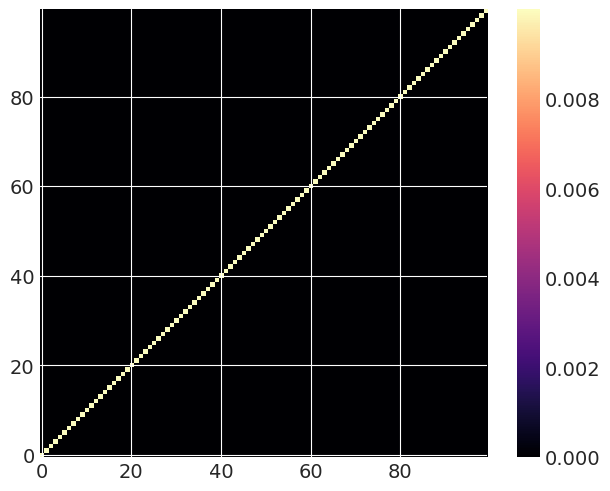

In [13]:
plt.imshow(obs_cov, cmap='magma', origin='lower')
plt.colorbar()

# Define the forward model for the Kalman inversion

In [14]:
gravity_solver = Gravity_Forward(depth, n_quad, n_data)
gravity_solver.set_random_process(Matern52, lamb, mkl)

def gsolve(mean, stdev, theta, solver=gravity_solver):
    solver.solve(mean, stdev, theta)
    return solver.get_data()

/tmp/ipykernel_867474/191944427.py:52: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  eigvals, eigvecs = eigh(self.cov, eigvals=(self.n_points - self.mkl, self.n_points - 1))


# Numpyro model

In [19]:
def numpyro_gravity_model(data, obs_cov):
    
    mu = numpyro.sample('mu', dist.Normal(0.0, 1.0))
    stdev = numpyro.sample('stdev', dist.HalfNormal(0.2))
    theta = numpyro.sample('theta', dist.Normal(jnp.zeros(mkl), jnp.ones(mkl)))
    obs_sim = gsolve(mu, stdev, theta)
    llk = numpyro.sample('llk', dist.MultivariateNormal(loc=obs_sim, covariance_matrix=obs_cov), obs=data)

In [20]:
def run_inference(model, num_warmup, num_samples, num_chains, rng_key, data, cov):
    kernel = NUTS(model, max_tree_depth=7)
    mcmc = MCMC(
        kernel,
        num_warmup=num_warmup,
        num_samples=num_samples,
        num_chains=num_chains,
        progress_bar=True,
        chain_method='vectorized'
    )
    mcmc.run(rng_key, data, cov)
    mcmc.print_summary()
    return mcmc, mcmc.get_samples()

In [21]:
mcmc, samples = run_inference(numpyro_gravity_model, 5000, 50000, 2, jax.random.PRNGKey(0), data, obs_cov)

sample: 100%|██████████| 55000/55000 [57:55<00:00, 15.83it/s] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      0.46      0.14      0.46      0.23      0.70   3667.50      1.00
     stdev      0.31      0.05      0.30      0.23      0.38   2787.43      1.00
  theta[0]      0.82      0.78      0.82     -0.47      2.10   3771.31      1.00
  theta[1]     -0.47      0.07     -0.47     -0.59     -0.35   2869.17      1.00
  theta[2]     -0.39      0.06     -0.38     -0.49     -0.28   3017.08      1.00
  theta[3]     -0.07      0.05     -0.07     -0.15      0.00  10814.05      1.00
  theta[4]     -1.10      0.48     -1.10     -1.89     -0.32   3790.53      1.00
  theta[5]     -2.23      0.34     -2.22     -2.77     -1.67   2703.29      1.00
  theta[6]     -0.04      0.09     -0.04     -0.19      0.11  12100.84      1.00
  theta[7]     -0.32      0.10     -0.31     -0.48     -0.15   7017.25      1.00
  theta[8]     -0.26      0.14     -0.25     -0.48     -0.02  11291.48      1.00
  theta[9]      0.17      0

In [22]:
idata = az.from_numpyro(mcmc)

array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'stdev'}>,
        <Axes: title={'center': 'stdev'}>],
       [<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

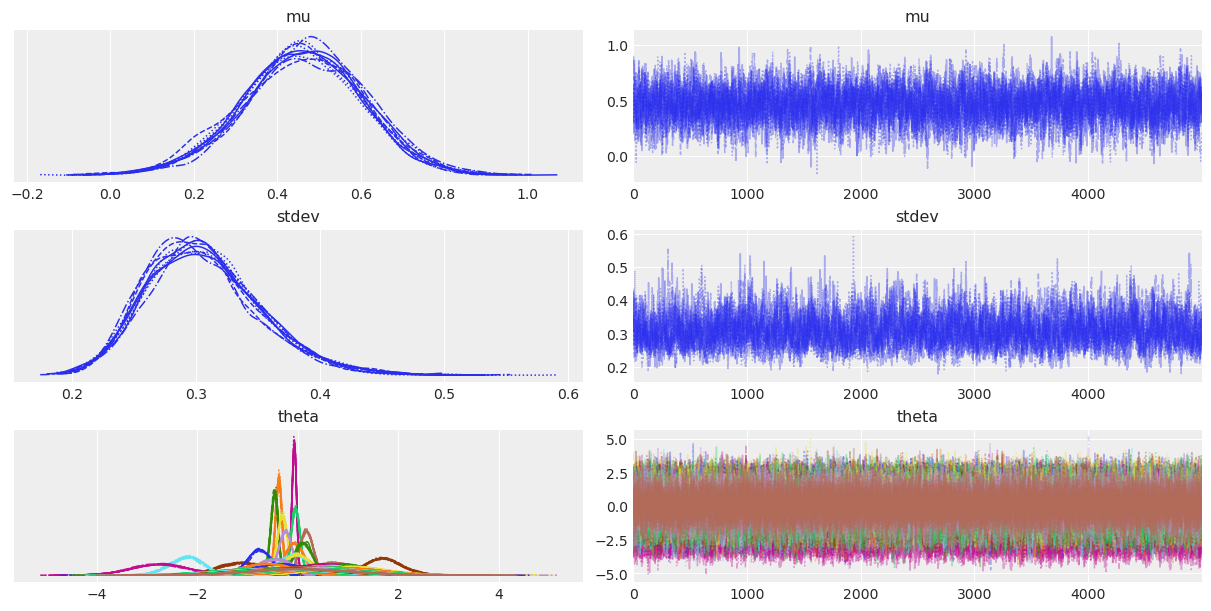

In [23]:
az.plot_trace(idata)

/global/homes/r/rgrumitt/.conda/envs/jax/lib/python3.10/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
/global/homes/r/rgrumitt/.conda/envs/jax/lib/python3.10/site-packages/arviz/plots/backends/matplotlib/pairplot.py:232: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


array([[<Axes: ylabel='stdev'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='theta\n0'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='theta\n1'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='theta\n2'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='theta\n3'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='theta\n4'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='theta\n5'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='mu', ylabel='theta\n6'>, <Axes: xlabel='stdev'>,
        <Axes: xlabel='theta\n0'>, <Axes: xlabel='theta\n1'>,
        <Axes: xlabel='theta\n2'>, <Axes: xlabel='theta\n3'>,
        <

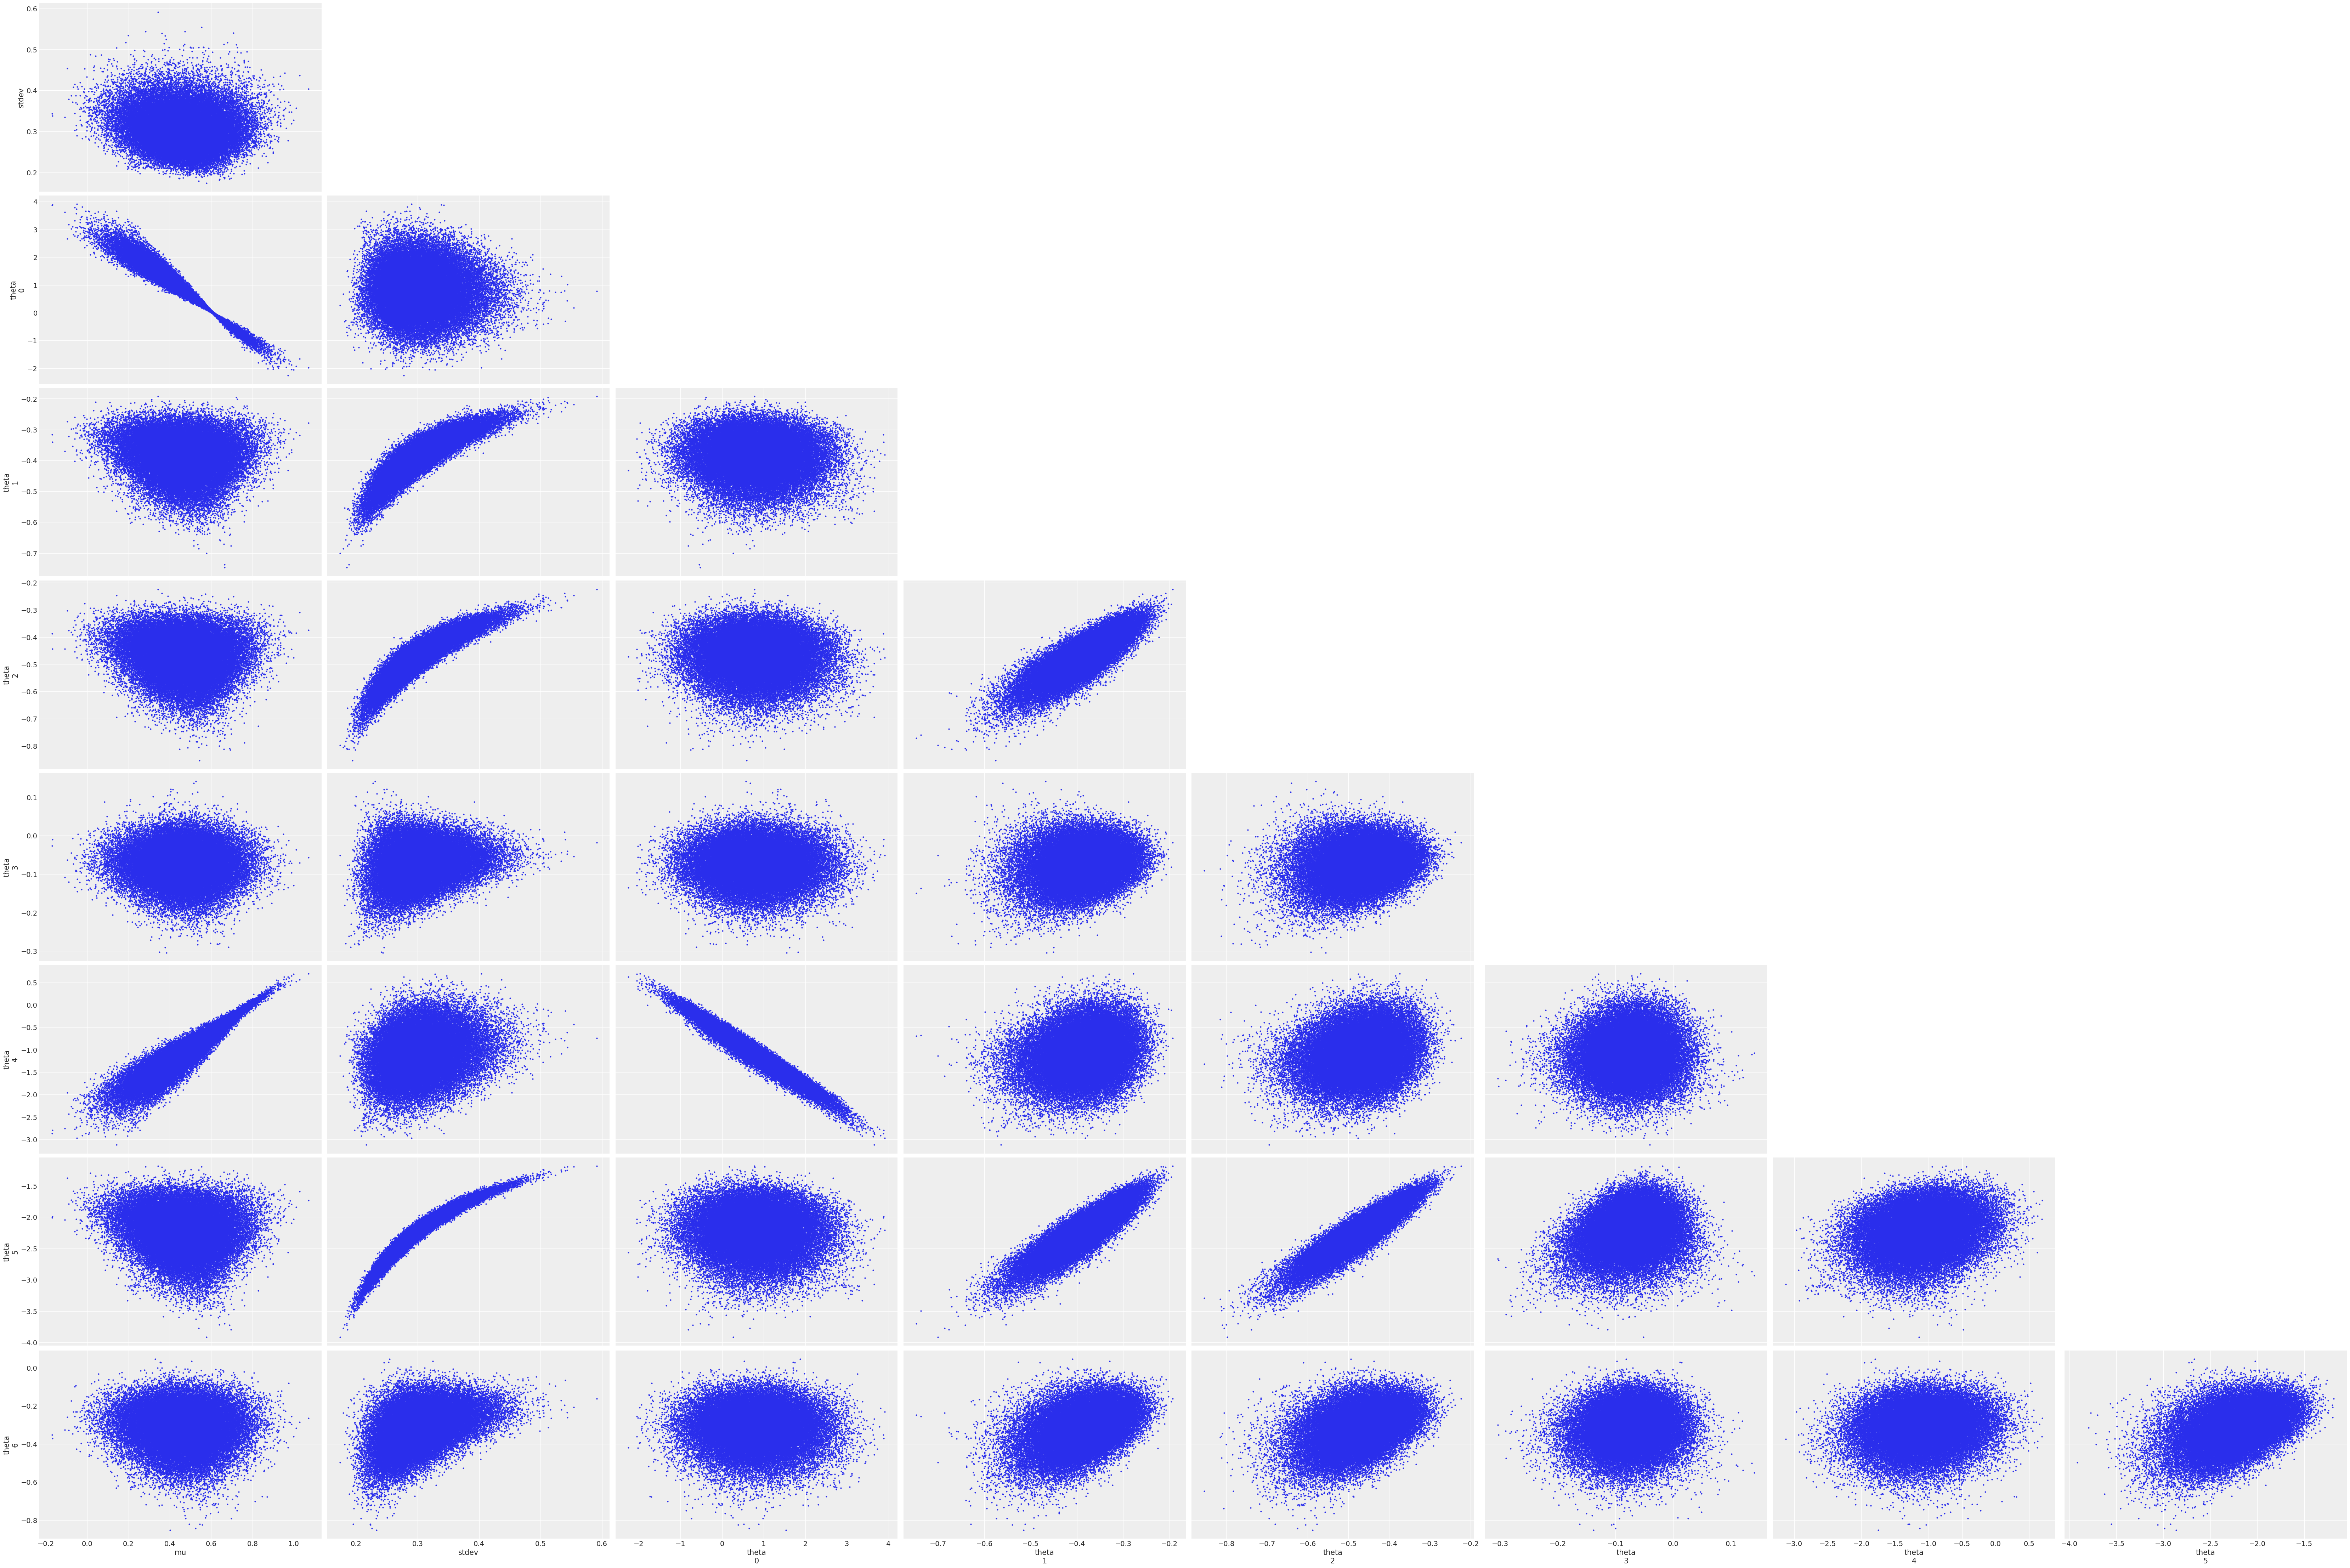

In [24]:
az.plot_pair(idata)